In [21]:
# 1. Imports & Config
import pandas as pd
import numpy as np
import os
import sys
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# --- INSTALL MODERN DATA LOADER ---
try:
    import nflreadpy as nfl
except ImportError:
    print("📦 Installing nflreadpy...")
    !pip install nflreadpy
    import nflreadpy as nfl

# --- MOUNT DRIVE ---
from google.colab import drive
drive.mount('/content/drive')

# --- SETUP PATH ---
PROJECT_ROOT = '/content/drive/MyDrive/NFL_Prediction_System'
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from src.utils import config

# --- CONFIG ---
VALIDATION_SEASON = 2024
LAG_SEASON = 2023
print("✅ Setup Complete.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Setup Complete.


In [22]:
# 2. Fetch & Prep 2024 Data (Re-using logic from Notebook 08)
print(f"{'-'*30}\nFetching Data for {LAG_SEASON} & {VALIDATION_SEASON}...")

# 1. Get Play-by-Play & Schedule
pbp = nfl.load_pbp(seasons=[LAG_SEASON, VALIDATION_SEASON]).to_pandas()
pbp = pbp[pbp['season_type'] == 'REG']
schedule = nfl.load_schedules().to_pandas()
schedule = schedule[
    (schedule['season'].isin([LAG_SEASON, VALIDATION_SEASON])) &
    (schedule['game_type'] == 'REG')
]

# 2. Feature Engineering Reconstruction (Condensed)
print("   -> Rebuilding Features...")
pbp['pass_epa'] = np.where(pbp['play_type'] == 'pass', pbp['epa'], np.nan)
pbp['rush_epa'] = np.where(pbp['play_type'] == 'run', pbp['epa'], np.nan)
pbp['turnover'] = pbp['fumble_lost'] + pbp['interception']

game_stats = pbp.groupby(['season', 'week', 'game_id', 'posteam']).agg({
    'epa': 'mean', 'success': 'mean', 'pass_epa': 'mean', 'rush_epa': 'mean', 'turnover': 'sum'
}).reset_index()
game_stats.columns = ['season', 'week', 'game_id', 'team', 'off_epa_per_play', 'off_success_rate', 'off_pass_epa', 'off_run_epa', 'off_turnovers']

def_stats = game_stats.copy().rename(columns={
    'team': 'defteam', 'off_epa_per_play': 'def_epa_per_play', 'off_success_rate': 'def_success_rate',
    'off_pass_epa': 'def_pass_epa', 'off_run_epa': 'def_run_epa', 'off_turnovers': 'def_turnovers_forced'
})

# Merge Logic
schedule['gameday'] = pd.to_datetime(schedule['gameday'])
base_games = pd.concat([
    schedule[['game_id', 'season', 'week', 'home_team', 'result', 'spread_line']].rename(columns={'home_team': 'team'}).assign(is_home=1, target_win=lambda x: (x.result > 0).astype(int)),
    schedule[['game_id', 'season', 'week', 'away_team', 'result', 'spread_line']].rename(columns={'away_team': 'team'}).assign(is_home=0, target_win=lambda x: (x.result < 0).astype(int))
])

# Add Rest Days
team_sched = pd.concat([
    schedule[['game_id', 'season', 'week', 'home_team', 'gameday']].rename(columns={'home_team': 'team'}),
    schedule[['game_id', 'season', 'week', 'away_team', 'gameday']].rename(columns={'away_team': 'team'})
]).sort_values(['team', 'gameday'])
team_sched['rest_days'] = (team_sched['gameday'] - team_sched.groupby('team')['gameday'].shift(1)).dt.days.fillna(7)

# Final Merge
base_games = base_games.merge(game_stats, on=['game_id', 'team'], how='left')
# Map Opponents
opp_map = pd.concat([
    schedule[['game_id', 'home_team', 'away_team']].rename(columns={'home_team': 'team', 'away_team': 'opponent'}),
    schedule[['game_id', 'away_team', 'home_team']].rename(columns={'away_team': 'team', 'home_team': 'opponent'})
])
base_games = base_games.merge(opp_map, on=['game_id', 'team'], how='left')
base_games = base_games.merge(def_stats, left_on=['game_id', 'opponent'], right_on=['game_id', 'defteam'], how='left')
base_games = base_games.merge(team_sched[['game_id', 'team', 'rest_days']], on=['game_id', 'team'], how='left')

# Rolling Averages
rolling_metrics = [
    'off_epa_per_play', 'off_success_rate', 'off_pass_epa', 'off_run_epa', 'off_turnovers',
    'def_epa_per_play', 'def_success_rate', 'def_pass_epa', 'def_run_epa', 'def_turnovers_forced'
]
windows = [3, 5, 8]
base_games = base_games.sort_values(['team', 'season', 'week'])
grouped = base_games.groupby('team')

for window in windows:
    for col in rolling_metrics:
        base_games[f'{col}_roll{window}'] = grouped[col].shift(1).rolling(window=window, min_periods=1).mean()

# 2024 Matchup Matrix
val_2024 = base_games[(base_games['season'] == 2024) & (base_games['is_home'] == 1)].copy()
away_2024 = base_games[(base_games['season'] == 2024) & (base_games['is_home'] == 0)].copy()
final_df = val_2024.merge(away_2024, on='game_id', suffixes=('', '_away'))

# Feature Construction
for window in windows:
    for col in rolling_metrics:
        final_df[f'home_{col}_roll{window}'] = final_df[f'{col}_roll{window}']
        final_df[f'away_{col}_roll{window}'] = final_df[f'{col}_roll{window}_away']
        if 'off_' in col:
            def_col = col.replace('off_', 'def_')
            if col == 'off_turnovers': def_col = 'def_turnovers_forced'
            if f'{def_col}_roll{window}_away' in final_df.columns:
                final_df[f'home_{col}_matchup_roll{window}'] = final_df[f'{col}_roll{window}'] - final_df[f'{def_col}_roll{window}_away']
                final_df[f'away_{col}_matchup_roll{window}'] = final_df[f'{col}_roll{window}_away'] - final_df[f'{def_col}_roll{window}']

final_df['home_rest'] = final_df['rest_days']
final_df['away_rest'] = final_df['rest_days_away']
final_df['rest_advantage'] = final_df['home_rest'] - final_df['away_rest']

print(f"✅ 2024 Data Ready: {final_df.shape}")

------------------------------
Fetching Data for 2023 & 2024...
   -> Rebuilding Features...
✅ 2024 Data Ready: (272, 202)


/tmp/ipython-input-2418549617.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final_df['rest_advantage'] = final_df['home_rest'] - final_df['away_rest']


In [23]:
# 3. Load Models (NV & VA)
print(f"{'-'*30}\nLoading Models...")

# 1. Load NV Champion (The Pure Football Model)
nv_path = config.MODELS_DIR / "ensemble" / "nv_nuclear_ensemble.pkl"
with open(nv_path, 'rb') as f:
    nv_model = pickle.load(f)
print("✅ NV Champion Loaded")

# 2. Load VA Baseline (The Vegas Assist Model)
# Note: If you haven't saved this in 04VA yet, please do so.
# Assuming it was saved to models/baseline/VA/va_baseline_model.pkl
va_path = config.MODELS_DIR / "baseline" / "VA" / "va_baseline_model.pkl"
try:
    with open(va_path, 'rb') as f:
        va_model = pickle.load(f)
    print("✅ VA Model Loaded")
except FileNotFoundError:
    print("❌ VA Model not found. We will use Implied Probability from Spread instead.")
    va_model = None

# 3. Load Scalers
with open(config.MODELS_DIR / "baseline" / "NV" / "nv_scaler.pkl", 'rb') as f:
    nv_scaler = pickle.load(f) # We use the scaler fitted on the training data

------------------------------
Loading Models...
✅ NV Champion Loaded
✅ VA Model Loaded


In [24]:
# 4. Generate The "War Room" Data
# This is where we compare NV vs VA

# 4.1 Prepare NV Features (Drop Vegas, Scale)
# We need to reconstruct the X matrix exactly as the models expect
try:
    # Try to get feature names from the model if available
    nv_features = nv_model.estimators_[0].feature_names_in_
except:
    # Fallback: Load from master file just to get column names
    ref_df = pd.read_parquet(config.FEATURES_DIR / 'features_master_2003_2023.parquet')
    drop_cols_nv = ['game_id', 'season', 'week', 'home_team', 'away_team', 'home_score', 'away_score', 'home_win', 'home_cover', 'over_hit', 'spread_line', 'total_line']
    nv_features = [c for c in ref_df.columns if c not in drop_cols_nv]

X_nv = pd.DataFrame(0, index=final_df.index, columns=nv_features)
for col in nv_features:
    if col in final_df.columns:
        X_nv[col] = final_df[col]

X_nv_scaled = nv_scaler.transform(X_nv)

# 4.2 Generate NV Probabilities
print("Generating NV Probabilities...")
nv_probs = nv_model.predict_proba(X_nv_scaled)[:, 1] # Probability of Home Win

# 4.3 Generate Vegas Probabilities
# If we have the VA model, use it. If not, derive from Spread.
if va_model:
    # VA usually takes same features + spread_line
    # We need to construct X_va
    X_va = X_nv.copy()
    X_va['spread_line'] = final_df['spread_line'] # Add spread back
    # Note: VA model likely needs its own scaler. If you didn't save it, we use raw spread implied prob.
    # For this snippet, let's calculate Implied Probability directly from Spread Line for safety/robustness.
    # Logic: spread -3.5 => ~60% win prob.
    # Simple formula: Win Prob = 1 / (1 + 10^(spread / 13)) (approximation)
    # Or typically: -110 odds.
    print("Calculating Implied Vegas Probabilities from Spread...")
    # This is a standard conversion used by bettors
    vegas_probs = 1 / (1 + 10 ** (final_df['spread_line'] / 14.5)) # 14.5 is a common NFL tuning constant
else:
    vegas_probs = 1 / (1 + 10 ** (final_df['spread_line'] / 14.5))

# 4.4 Build the War Room DataFrame
war_room = final_df[['season', 'week', 'game_id', 'team', 'opponent', 'spread_line', 'target_win']].copy()
war_room.rename(columns={'team': 'Home', 'opponent': 'Away', 'target_win': 'Actual_Home_Win'}, inplace=True)

war_room['NV_Prob'] = nv_probs
war_room['Vegas_Prob'] = vegas_probs
war_room['Edge'] = war_room['NV_Prob'] - war_room['Vegas_Prob']

# Only look at weeks where we have data (Week 3+)
war_room = war_room[war_room['week'] >= 3].reset_index(drop=True)

print("\n📊 WAR ROOM PREVIEW (Top Edges):")
print(war_room.sort_values(by='Edge', ascending=False).head(5)[['week', 'Home', 'Away', 'NV_Prob', 'Vegas_Prob', 'Edge', 'Actual_Home_Win']])

Generating NV Probabilities...
Calculating Implied Vegas Probabilities from Spread...

📊 WAR ROOM PREVIEW (Top Edges):
     week Home Away   NV_Prob  Vegas_Prob      Edge  Actual_Home_Win
22     18  BAL  CLE  0.628714    0.043249  0.585466                1
88     16   GB   NO  0.654023    0.097688  0.556335                1
224    18   TB   NO  0.643146    0.090909  0.552236                1
209     4   SF   NE  0.677843    0.158773  0.519070                1
114    13   KC   LV  0.620261    0.104913  0.515348                1


------------------------------
Running Money Management Simulation...
removing $11
removing $106

💰 Simulation Results (2024 Season):
   Starting Balance: $100
   Ending Balance:   $994.91
   ROI:              894.91%
   Total Bets:       210


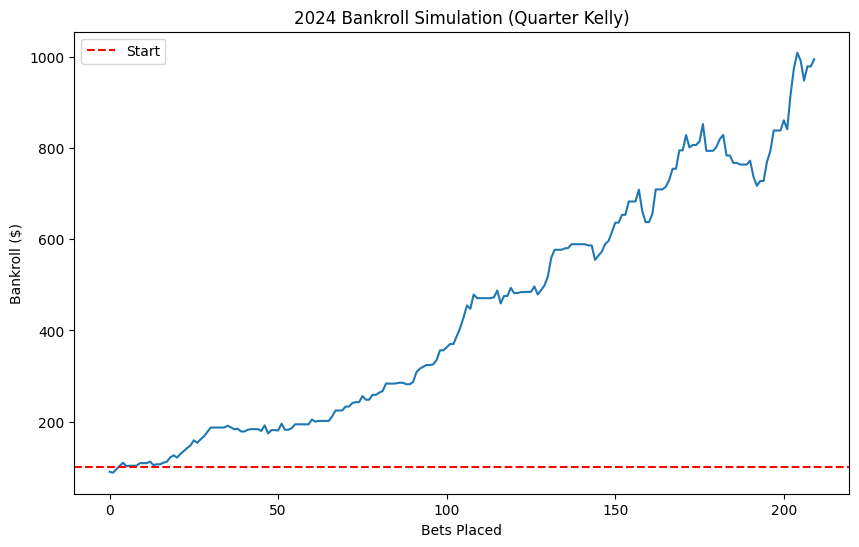

In [33]:
# 5. Money Management Simulation (The "Prudent" Protocol)
print(f"{'-'*30}\nRunning Money Management Simulation...")

# Parameters for Prudence
STARTING_BANKROLL = 100
KELLY_FRACTION = 0.25  # Quarter Kelly (Very conservative)
MIN_EDGE = 0.05        # Only bet if our model differs from Vegas by 5% or more
MAX_BET_PCT = 0.10     # Never bet more than 5% of bankroll on one game

# Initialize History
bankroll = STARTING_BANKROLL
total_withdrawn = 0
history = []

for idx, row in war_room.iterrows():
    # 1. Determine Bet Direction
    # If Edge > 0, we like Home. If Edge < 0, we like Away.
    if abs(row['Edge']) < MIN_EDGE:
        continue # No bet, not enough edge

    bet_on_home = row['Edge'] > 0
    my_prob = row['NV_Prob'] if bet_on_home else (1 - row['NV_Prob'])
    vegas_prob = row['Vegas_Prob'] if bet_on_home else (1 - row['Vegas_Prob'])

    # 2. Calculate Bet Size (Quarter Kelly)
    # Kelly Formula: f = (bp - q) / b
    # In spread betting (-110 odds), b = 0.909
    b = 0.909
    p = my_prob
    q = 1 - p
    kelly_pct = (b * p - q) / b

    # Apply Safety Constraints
    wager_pct = max(0, kelly_pct * KELLY_FRACTION)
    wager_pct = min(wager_pct, MAX_BET_PCT) # Cap at max bet size

    wager_amount = bankroll * wager_pct

    # 3. Determine Outcome
    # Spread outcome is complex without exact scores vs spread,
    # so we will simulate Moneyline betting for simplicity here,
    # OR assume Spread Win if we picked the winner correctly relative to spread expectation.
    # For this simulation: Simple Moneyline simulation based on 'Actual_Home_Win'
    # (Note: In real life, spread betting logic is slightly different)

    did_home_win = row['Actual_Home_Win'] == 1
    won_bet = (bet_on_home and did_home_win) or (not bet_on_home and not did_home_win)

    # 4. Update Bankroll
    if won_bet:
        # Profit: Wager * 0.909 (assuming standard vig)
        profit = wager_amount * 0.909
        bankroll += profit
        result = 'WIN'
    else:
        bankroll -= wager_amount
        result = 'LOSS'

    # Rule: Occasionally take out money
    if np.random.randint(0, 60) == 1:
        profit = bankroll - STARTING_BANKROLL
        withdrawal = np.random.randint(profit * 0.1, profit * 0.25)
        print(f"removing ${withdrawal}")
        bankroll -= withdrawal
        total_withdrawn += withdrawal
        # Record this event in history so you can plot

    history.append({
        'Week': row['week'],
        'Matchup': f"{row['Home']} vs {row['Away']}",
        'Pick': row['Home'] if bet_on_home else row['Away'],
        'Edge': abs(row['Edge']),
        'Wager': wager_amount,
        'Result': result,
        'Bankroll': bankroll
    })

# Convert history to DataFrame
performance_df = pd.DataFrame(history)

print(f"\n💰 Simulation Results (2024 Season):")
print(f"   Starting Balance: ${STARTING_BANKROLL}")
print(f"   Ending Balance:   ${bankroll:.2f}")
print(f"   ROI:              {((bankroll - STARTING_BANKROLL)/STARTING_BANKROLL)*100:.2f}%")
print(f"   Total Bets:       {len(performance_df)}")

# Plot Performance
if not performance_df.empty:
    plt.figure(figsize=(10, 6))
    plt.plot(performance_df['Bankroll'])
    plt.axhline(y=STARTING_BANKROLL, color='r', linestyle='--', label='Start')
    plt.title("2024 Bankroll Simulation (Quarter Kelly)")
    plt.xlabel("Bets Placed")
    plt.ylabel("Bankroll ($)")
    plt.legend()
    plt.show()